In [1722]:
#We read in the necessary libraries.

import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
#import numpy as np
from scipy import stats
from tabulate import tabulate
import statsmodels.api as sm
from statsmodels.formula.api import ols
from tqdm import tqdm
from statistics import median
import scikit_posthocs as sp
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from itertools import chain
import numpy as np
from tqdm import tqdm; tqdm.pandas()
import ast

In [1723]:
#We read in all our data.
df = pd.read_csv("Newspapers_Complete.csv")

In [1724]:
#We inspect it.
df.head()

Author  Background  Character count  Culture Day of the week  Domestic  \
0  unknown       False           3286.0    False       Wednesday     False   
1  unknown       False           3286.0    False       Wednesday     False   
2  unknown       False           3286.0    False       Wednesday     False   
3  unknown       False           3286.0    False       Wednesday     False   
4  unknown       False           3286.0    False       Wednesday     False   

   Foreign  Frontpage  Half-life  Highlighted  ...  \
0    False       True         28        False  ...   
1    False       True         28        False  ...   
2    False       True         28        False  ...   
3    False       True         28        False  ...   
4    False       True         28        False  ...   

                      Section trees  Shelf-life  Slope after peak  \
0  ['ge/extra/opinie-column', 'ge']          38               0.0   
1  ['ge/extra/opinie-column', 'ge']          38               0.0   
2  ['ge/extra/opinie-column', 'ge']          38               0.0   
3  ['ge/extra/opinie-column', 'ge']          38               0.0   
4  ['ge/extra/opinie-column', 'ge']          38               0.0   

  Slope before peak  Sport Time of the day       Timestamp date  Total views  \
0          0.176591  False              19  2021-05-26 19:00:00            3   
1          0.176591  False              20  2021-05-26 20:00:00            3   
2          0.176591  False              21  2021-05-26 21:00:00            3   
3          0.176591  False              22  2021-05-26 22:00:00            3   
4          0.176591  False              23  2021-05-26 23:00:00            3   

   Views  Views in 1st 2h  
0      0                0  
1      0                0  
2      0                0  
3      0                0  
4      0                0  

[5 rows x 36 columns]

In [1725]:
#We fill up spaces and special symbols in our column names (as otherwise they will not work in formula et cetera).
df.columns = [c.replace(" ", "_").replace("-", "_").replace("(", "").replace(")", "").replace(".", "") for c in df.columns]

In [1726]:
#We inspect the column names.
df.columns

Index(['Author', 'Background', 'Character_count', 'Culture', 'Day_of_the_week',
       'Domestic', 'Foreign', 'Frontpage', 'Half_life', 'Highlighted',
       'Hours_passed', 'Hours_till_peak', 'Inline_media', 'Landing_page',
       'Lifestyle', 'Newspaper', 'Number_of_sections_excl_frontpage',
       'Number_of_sections_incl_frontpage', 'Opinion', 'Paid_content',
       'Popularity', 'Popularity_rank', 'Popularity_rank_in_1st_2h',
       'Publication_date', 'Recommended', 'Regional', 'Section_trees',
       'Shelf_life', 'Slope_after_peak', 'Slope_before_peak', 'Sport',
       'Time_of_the_day', 'Timestamp_date', 'Total_views', 'Views',
       'Views_in_1st_2h'],
      dtype='object')

In [1727]:
#To be sure we once again check if there are duplicates.
print(df.duplicated().value_counts())

False    17784352
dtype: int64


## Categorizing Time of the Day

In [1728]:
df.rename(columns={"Time_of_the_day": "Time_of_the_day_num"}, inplace=True)

In [1729]:
def get_time_of_the_day_cat(x):
    if (x < 6) or x == 24:
        return "night"
    elif x < 9:
        return "early morning"
    elif x < 12:
        return "late morning"
    elif x < 15:
        return "early afternoon"
    elif x < 18:
        return "late afternoon"
    elif x < 21:
        return "early evening"
    elif x < 24:
        return "late evening"

order = ["night", "early morning", "late morning", "early afternoon", "late afternoon", "early evening", "late evening"]

In [1730]:
df["Time_of_the_day"] = df.Time_of_the_day_num.progress_apply(lambda x: get_time_of_the_day_cat(x))
df["Time_of_the_day"] = df.Time_of_the_day.astype("category").cat.reorder_categories(order, ordered=True)

100%|██████████| 17784352/17784352 [00:21<00:00, 843004.30it/s]


In [1731]:
df.columns

Index(['Author', 'Background', 'Character_count', 'Culture', 'Day_of_the_week',
       'Domestic', 'Foreign', 'Frontpage', 'Half_life', 'Highlighted',
       'Hours_passed', 'Hours_till_peak', 'Inline_media', 'Landing_page',
       'Lifestyle', 'Newspaper', 'Number_of_sections_excl_frontpage',
       'Number_of_sections_incl_frontpage', 'Opinion', 'Paid_content',
       'Popularity', 'Popularity_rank', 'Popularity_rank_in_1st_2h',
       'Publication_date', 'Recommended', 'Regional', 'Section_trees',
       'Shelf_life', 'Slope_after_peak', 'Slope_before_peak', 'Sport',
       'Time_of_the_day_num', 'Timestamp_date', 'Total_views', 'Views',
       'Views_in_1st_2h', 'Time_of_the_day'],
      dtype='object')

In [1732]:
order2 = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
df["Day_of_the_week"] = df.Day_of_the_week.astype("category").cat.reorder_categories(order2, ordered=True)

In [1734]:
df.Day_of_the_week.cat.categories[0]

'Sunday'

## Transforming File

In [1735]:
#We create a non-lagged file for most of our analyses.
df_1 = df.groupby(["Newspaper", "Landing_page"]).nth(0).reset_index()

## Proportion 1-day Tracked Publications

In [1736]:
df.Timestamp_date.max()

'2021-07-11 23:00:00'

In [1737]:
oneday = df_1[df_1.Publication_date > '2021-07-11 00:00:00']["Publication_date"]

In [1738]:
print(len(oneday)); round((len(oneday)/len(df_1))*100, 2)

289


0.62

## Correlation Views and Shelf-life on the Newspaper Level

In [1739]:
np_total_views = df_1.groupby("Newspaper")[["Total_views"]].mean().reset_index(); np_total_views.sort_values("Total_views")

Newspaper  Total_views
2       Ijmuidercourant    59.979468
3        Leidschdagblad   202.231905
0       Gooieneemlander   219.784733
1       Haarlemsdagblad   270.127983
4  Noordhollandsdagblad   471.518648

In [1740]:
np_shelf_life = df_1.groupby("Newspaper")[["Shelf_life"]].median().reset_index(); np_shelf_life.sort_values("Shelf_life")

Newspaper  Shelf_life
0       Gooieneemlander        14.0
2       Ijmuidercourant        15.0
3        Leidschdagblad        28.0
1       Haarlemsdagblad        38.0
4  Noordhollandsdagblad        72.0

In [1741]:
np_metrics = pd.concat([np_total_views, np_shelf_life], axis=1); np_metrics.corr()

Total_views  Shelf_life
Total_views     1.000000    0.918318
Shelf_life      0.918318    1.000000

## Descriptives

In [1742]:
#We calculate some basic numbers.
print(f'Total number of articles: {len(df["Landing_page"].unique())} articles')
print(f'Total number of publications: {len(df_1)} publications')
print(f'Total number of views: {df_1["Total_views"].sum()} views')
print(f'Aggregate median of shelf-life: {median(df_1["Shelf_life"])} hour per publication')
print(f'Aggregate median absolute deviation of shelf-life: {int(stats.median_abs_deviation(df_1["Shelf_life"]))} hour per publication')
print(f'Aggregate mean of total views: {np.mean(df_1["Total_views"]):.0f} views per publication')
print(f'Aggregate standard deviation of total views: {np.std(df_1["Total_views"]):.0f} views per publication')
print(f'Aggregate mean of hours tracked: {np.mean(df.groupby(["Newspaper", "Landing_page"])["Hours_passed"].max()):.0f} hours per publication')
print(f'Aggregate standard deviation of hours tracked: {np.std(df.groupby(["Newspaper", "Landing_page"])["Hours_passed"].max()):.0f} hours per publication')

Total number of articles: 19685 articles
Total number of publications: 46550 publications
Total number of views: 13369338 views
Aggregate median of shelf-life: 34.0 hour per publication
Aggregate median absolute deviation of shelf-life: 32 hour per publication
Aggregate mean of total views: 287 views per publication
Aggregate standard deviation of total views: 2038 views per publication
Aggregate mean of hours tracked: 382 hours per publication
Aggregate standard deviation of hours tracked: 514 hours per publication


In [1743]:
#We also inspect how often an article is published (thus on how many newspapers).
print("Number of publications per article:")
Counter(df_1["Landing_page"].value_counts())

Number of publications per article:


Counter({5: 2905, 4: 2519, 3: 2949, 2: 1790, 1: 9522})

## Compare views and ranking

In [1744]:
quantile_99 = df[df.Hours_passed == 1].Views.quantile(0.99); print(quantile_99)

289.0


In [1745]:
df[(df.Hours_passed == 1) & (df.Views >= quantile_99)][["Landing_page", "Views", "Popularity_rank"]]\
.sort_values(by="Popularity_rank", ascending=False)

Landing_page  Views  Popularity_rank
15871037  /cnt/dmf20210602_18737134    346              8.0
17591940  /cnt/dmf20210629_40958980    294              8.0
15928193  /cnt/dmf20210602_70665109    349              7.0
14034326  /cnt/dmf20210515_71185898    444              7.0
9568275   /cnt/dmf20210418_31709160    391              7.0
...                             ...    ...              ...
7540477   /cnt/dmf20210607_63519090    418              1.0
7511186   /cnt/dmf20210605_68304755    962              1.0
7494098   /cnt/dmf20210604_61399847    519              1.0
7454247   /cnt/dmf20210603_33423161    357              1.0
12128606  /cnt/dmf20210501_18794464   8250              1.0

[467 rows x 3 columns]

## RQ1: Views x Hours

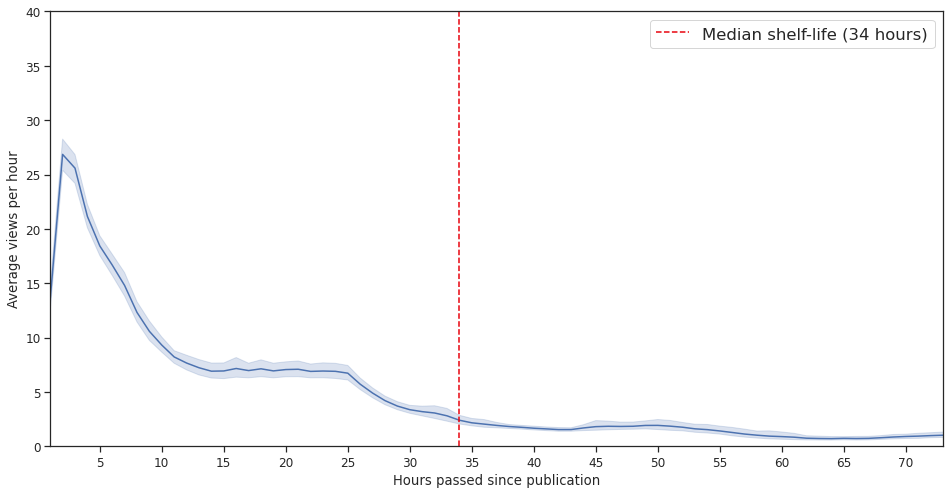

In [173]:
#We create a figure where we plot hours passed against views per hour.
#Since incidental views can extend the long-tail of an article, we cut the graph on the 72 hour mark (thus we show 3 days).
#In addition we add a dotted line to highlight where the median shelf-life is.
fig, ax = plt.subplots(figsize=(16,8))

sns.set(style="ticks", font_scale=1.5, palette="bright")

sns.lineplot(x="Hours_passed", y="Views", data=df, ax=ax)

ax.set_xlabel("Hours passed since publication")
ax.set_ylabel("Average views per hour")

ax.set_xticks(np.arange(0,73,5))

ax.set_xlim(1,73)
ax.set_ylim(0,40)

plt.axvline(x=34, color = "r", linestyle = "--", label="Median shelf-life (34 hours)")
plt.legend()
            
plt.savefig("Hours passed x Number of views.pdf", format="pdf", bbox_inches="tight")

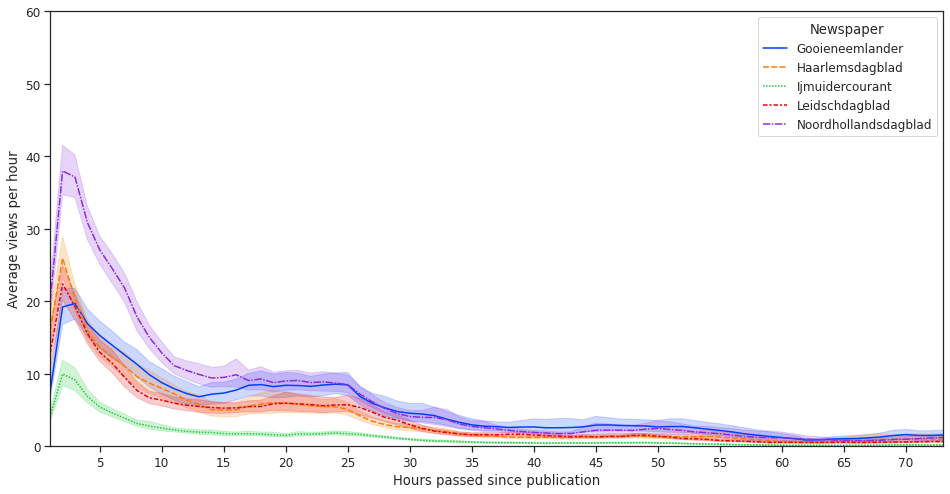

In [308]:
#We do the same as in the previous figure but it is now grouped per newspaper.
fig, ax = plt.subplots(figsize=(16,8))

sns.set(style="ticks", font_scale=1.1, palette="bright")

sns.lineplot(x="Hours_passed", y="Views", hue="Newspaper", style="Newspaper", data=df, ax=ax)

ax.set_xlabel("Hours passed since publication")
ax.set_ylabel("Average views per hour")

ax.set_xticks(np.arange(0,73,5))

ax.set_xlim(1,73)
ax.set_ylim(0,60)

plt.savefig("Hours passed x Number of views x Source.pdf", format="pdf", bbox_inches="tight")

In [175]:
#We inspect the shelf-life per newspaper.
df_1.groupby("Newspaper")["Shelf_life"].describe()

count        mean         std  min   25%   50%    75%  \
Newspaper                                                                       
Gooieneemlander        7061.0   94.685314  247.917924  1.0   2.0  14.0   48.0   
Haarlemsdagblad        6118.0  156.869565  298.948797  1.0  18.0  38.0  126.0   
Ijmuidercourant        8572.0   81.864559  218.441777  1.0   1.0  15.0   48.0   
Leidschdagblad         7585.0  130.657350  275.340916  1.0   3.0  28.0   94.0   
Noordhollandsdagblad  17214.0  262.621006  394.049515  1.0  27.0  72.0  324.0   

                         max  
Newspaper                     
Gooieneemlander       2091.0  
Haarlemsdagblad       2031.0  
Ijmuidercourant       2115.0  
Leidschdagblad        2045.0  
Noordhollandsdagblad  2112.0

## H1: Length x Shelf-life

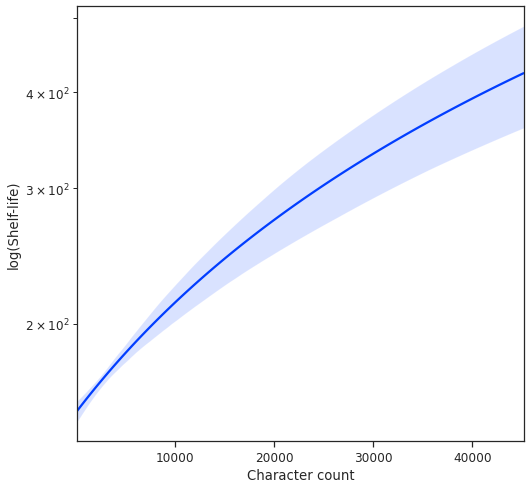

In [176]:
#We plot the characted count against the logarithm of shelf-life.
fig, ax = plt.subplots(figsize=(8,8))

sns.set(style="ticks", font_scale=1.5, palette="bright")

sns.regplot(x="Character_count", y="Shelf_life", data=df_1, ax=ax, scatter=False)

ax.set(yscale="log", xlabel="Character count", ylabel="log(Shelf-life)")

plt.savefig("Shelf-life x Character count.pdf", format="pdf", bbox_inches="tight")

In [177]:
#We create a function that performs a Spearman's rank correlation.
def report_spearman(x,y):
    #We create the rho and p value.
    rho, p = stats.spearmanr(x, y)
    #We create the degrees of freedom.
    df = len(x) - 2
    #We print it formatted by decimal count.
    print(f"rho: {rho:.2f}\ndf: {df}\np: {p:.3f}")

In [300]:
#We create a function to perform t-tests for the dummy variables.
def report_ttest(listx, listy):
    #We define two objects for the value possibilities (TRUE or FALSE) of the grouping variable.
    #cat1 = listx.unique()[0]
    #cat2 = listx.unique()[1]
    cat1 = True
    cat2 = False
    
    #We create two empty list.
    group1 = []
    group2 = []
    
    #We loop over the x and y values.
    for x,y in zip(listx, listy):
        #If the x (the dummy) has the value of the first category, it is appended to its respective empty list.
        if x == cat1:
            group1.append(y)
        #If the x has the value of the second category, it is appended to that list.
        elif x == cat2:
            group2.append(y)
            
    #We perform a Levene´s f-test.
    F, p = stats.levene(group1, group2)
    print(f"Levene's test\nF: {F:.2f}\np: {p:.3f}")
    
    #We calculate the degrees of freedom.
    df = len(group1 + group2) - 2
    
    #We perform a 'regular' independent t-test.
    t, p = stats.ttest_ind(group1, group2)
    print(f"Independent t-test\nt: {t:.2f}\ndf: {df}\np: {p:.3f}")
    
    #As well as a Welch's t-test.
    t, p = stats.ttest_ind(group1, group2, equal_var=False)
    print(f"Welch´s t-test\nt: {t:.2f}\ndf: {df}\np: {p:.3f}")

In [301]:
report_ttest(df_1["Background"], df_1["Character_count"])

Levene's test
F: 1011.82
p: 0.000
Independent t-test
t: 39.93
df: 46548
p: 0.000
Welch´s t-test
t: 20.99
df: 46548
p: 0.000


In [302]:
round(df_1.groupby("Background")["Character_count"].describe(), 2)

count     mean      std    min     25%     50%     75%      max
Background                                                                   
False       45495.0  2465.79  1965.60  146.0  1264.0  1913.0  3010.0  45161.0
True         1055.0  4989.49  3893.92  294.0  1729.0  4326.0  6892.0  25454.0

In [303]:
#We perform the function on character count and shelf-life.
report_spearman(df_1["Character_count"], df_1["Shelf_life"])

rho: 0.17
df: 46548
p: 0.000


### Validating on subsample

In [441]:
import krippendorff

In [433]:
df_txt = pd.read_csv("text_of_publications.csv", index_col=0)
df_txt["url"] = df_txt.url.str.split(".nl").str[1]
df_txt.drop_duplicates(inplace=True)
df_txt.rename(columns={"url":"Landing_page", "meta-script.article_title":"Title", "description":"Blurb"}, inplace=True)

In [434]:
df_lngth = df_1[["Landing_page", "Background", "Character_count"]]
df_lngth.drop_duplicates(inplace=True)

In [435]:
df_val = df_lngth.merge(df_txt, on="Landing_page")
df_val = df_val.groupby("Background").sample(min(df_val.Background.value_counts()), random_state=1).sample(frac=1, random_state=1).reset_index()

In [454]:
round(df_val.groupby("Background")["Character_count"].describe(), 2)

count     mean      std     min     25%     50%     75%      max
Background                                                                  
0            43.0  2425.07  1545.93   490.0  1131.0  1935.0  3256.5   7879.0
1            57.0  5603.61  4072.23  1110.0  2808.0  5201.0  6881.0  25454.0

In [436]:
df_val[["Title", "Blurb"]].to_excel("background_validation.xlsx")

In [437]:
df_val_coded = pd.read_excel("background_validation_coded.xlsx", index_col=0)["Code"]
df_val["Code"] = df_val_coded.values
df_val.dropna(inplace=True)
df_val[["Background", "Code"]] = df_val[["Background", "Code"]].astype(int)

In [453]:
round(krippendorff.alpha([df_val.Background.tolist(), df_val.Code.tolist()],level_of_measurement="nominal"), 2)

0.73

In [452]:
round(df_val.groupby("Code")["Character_count"].describe(), 2)

count     mean      std     min      25%     50%      75%      max
Code                                                                    
0      40.0  2484.52  1945.95   490.0  1136.00  1877.5  2922.50   9980.0
1      60.0  5405.05  3957.97  1089.0  2742.75  4829.0  6798.25  25454.0

In [450]:
report_ttest(df_val["Code"], df_val["Character_count"])

Levene's test
F: 7.23
p: 0.008
Independent t-test
t: 4.33
df: 98
p: 0.000
Welch´s t-test
t: 4.90
df: 98
p: 0.000


## H2: Number of sections x Number of views (excl. frontpage)

In [182]:
#As stated before frontpage correlates too strongly with the number of sections if the frontpage is counted as well.
df_1[["Number_of_sections_incl_frontpage", "Number_of_sections_excl_frontpage", "Frontpage"]].corr()

Number_of_sections_incl_frontpage  \
Number_of_sections_incl_frontpage                           1.000000   
Number_of_sections_excl_frontpage                           0.504933   
Frontpage                                                   0.916034   

                                   Number_of_sections_excl_frontpage  \
Number_of_sections_incl_frontpage                           0.504933   
Number_of_sections_excl_frontpage                           1.000000   
Frontpage                                                   0.116321   

                                   Frontpage  
Number_of_sections_incl_frontpage   0.916034  
Number_of_sections_excl_frontpage   0.116321  
Frontpage                           1.000000

In [183]:
df_1.groupby("Frontpage")["Number_of_sections_incl_frontpage"].describe()

count      mean       std  min  25%  50%  75%  max
Frontpage                                                      
False      34600.0  1.016156  0.146440  1.0  1.0  1.0  1.0  6.0
True       11950.0  2.070209  0.310242  2.0  2.0  2.0  2.0  8.0

In [184]:
#We count how often publications  are published on how many pages.
df_1.groupby("Number_of_sections_excl_frontpage")["Total_views"].describe()

count         mean           std     min  \
Number_of_sections_excl_frontpage                                               
1                                  45346.0   253.229193   1550.011371     1.0   
2                                   1067.0  1373.882849   7528.814328     1.0   
3                                    104.0  2455.326923  12208.433539    12.0   
4                                     14.0  8383.357143  19592.914291   104.0   
5                                     15.0  2648.600000   7723.506317    38.0   
6                                      3.0  1912.000000   1112.241431   632.0   
7                                      1.0  2288.000000           NaN  2288.0   

                                       25%     50%      75%       max  
Number_of_sections_excl_frontpage                                      
1                                     2.00     7.0    47.00  112701.0  
2                                    17.00    61.0   499.00  220184.0  
3                                    78.50   222.5   824.25  122780.0  
4                                   325.25   753.0  1399.50   55182.0  
5                                    64.00    88.0   923.50   30140.0  
6                                  1546.50  2461.0  2552.00    2643.0  
7                                  2288.00  2288.0  2288.00    2288.0

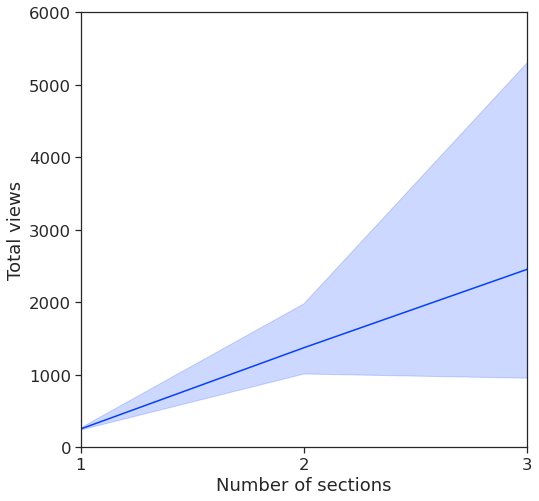

In [185]:
#We plot the number of sections excluding the frontpage against total views.
#We only plot up to three sections, since everything higher is rare.
fig, ax = plt.subplots(figsize=(8,8))

sns.set(style="ticks", font_scale=1.5, palette="bright")

sns.lineplot(x="Number_of_sections_excl_frontpage", y="Total_views", data=df_1, ax=ax)

ax.set_ylim(0,6000)
ax.set_xlim(1,3)

ax.set_xticks(np.arange(1,4,1))

ax.set(xlabel="Number of sections", ylabel="Total views")

plt.savefig("Number of sections x Total views V2.pdf", format="pdf", bbox_inches="tight")

In [186]:
#We also perform a spearman rank correlation for these two variables.
report_spearman(df_1["Number_of_sections_excl_frontpage"], df_1["Total_views"])

rho: 0.15
df: 46548
p: 0.000


In [187]:
report_spearman(df_1["Number_of_sections_incl_frontpage"], df_1["Total_views"])

rho: 0.62
df: 46548
p: 0.000


## H3: Home page x Number of views

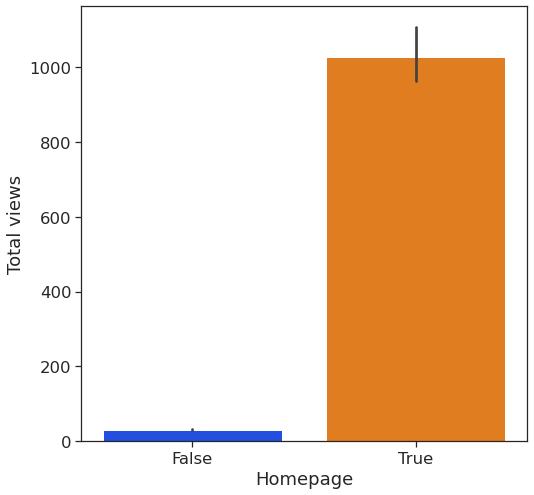

In [188]:
#We plot the frontpage dummy against the total views.
fig, ax = plt.subplots(figsize=(8,8))

sns.set(style="ticks", font_scale=1.5, palette="bright")

sns.barplot(x="Frontpage", y="Total_views", data=df_1, ax=ax)

ax.set_xlabel("Homepage")
ax.set_ylabel("Total views")

plt.savefig("Home page x Total views.pdf", format="pdf", bbox_inches="tight")

In [189]:
#We check the total views per frontpage dummy group.
df_1.groupby("Frontpage")["Total_views"].describe()

count         mean          std  min   25%    50%     75%  \
Frontpage                                                                
False      34600.0    31.355636   189.370238  1.0   1.0    4.0   14.00   
True       11950.0  1027.986025  3916.635448  1.0  39.0  179.0  743.75   

                max  
Frontpage            
False       12789.0  
True       220184.0

In [304]:
#We use the function on the frontpage dummy and total views.
report_ttest(df_1["Frontpage"], df_1["Total_views"])

Levene's test
F: 2025.48
p: 0.000
Independent t-test
t: 47.17
df: 46548
p: 0.000
Welch´s t-test
t: 27.81
df: 46548
p: 0.000


## H4: Highlighted x Number of views

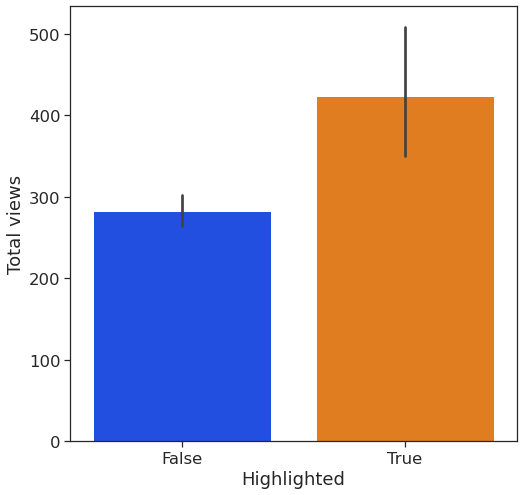

In [191]:
#We plot the highlighted dummy against number of views.
fig, ax = plt.subplots(figsize=(8,8))

sns.set(style="ticks", font_scale=1.1, palette="bright")

sns.barplot(x="Highlighted", y="Total_views", data=df_1, ax=ax)

ax.set_xlabel("Highlighted")
ax.set_ylabel("Total views")

plt.savefig("Highlighted x Total views.pdf", format="pdf", bbox_inches="tight")

In [192]:
#We describe it per group.
df_1.groupby("Highlighted")["Total_views"].describe()

count        mean          std  min   25%   50%    75%  \
Highlighted                                                             
False        44977.0  282.423461  2050.106536  1.0   2.0   7.0   47.0   
True          1573.0  423.889383  1653.824156  1.0  13.0  53.0  245.0   

                  max  
Highlighted            
False        220184.0  
True          36983.0

In [286]:
df_1.Highlighted.dtypes

dtype('bool')

In [305]:
#We report the t-test of it.
report_ttest(df_1["Highlighted"], df_1["Total_views"])

Levene's test
F: 5.87
p: 0.015
Independent t-test
t: 2.71
df: 46548
p: 0.007
Welch´s t-test
t: 3.30
df: 46548
p: 0.001


## H4: Recommended x Number of views

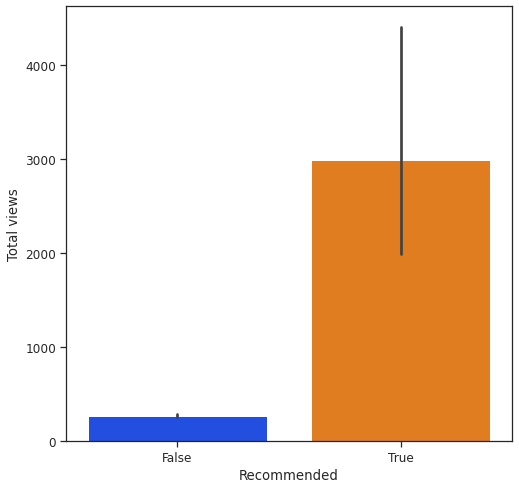

In [194]:
#We plot the recommended dummy against number of views.
fig, ax = plt.subplots(figsize=(8,8))

sns.set(style="ticks", font_scale=1.1, palette="bright")

sns.barplot(x="Recommended", y="Total_views", data=df_1, ax=ax)

ax.set_xlabel("Recommended")
ax.set_ylabel("Total views")

plt.savefig("Recommeded x Total views.pdf", format="pdf", bbox_inches="tight")

In [195]:
#We describe it per group.
df_1.groupby("Recommended")["Total_views"].describe()

count         mean           std  min    25%    50%      75%  \
Recommended                                                                   
False        46292.0   272.091052   1889.122198  1.0   2.00    8.0    50.00   
True           258.0  2998.833333  10106.665410  1.0  65.75  317.0  1598.75   

                  max  
Recommended            
False        220184.0  
True         122780.0

In [306]:
#We report its t-test.
report_ttest(df_1["Recommended"], df_1["Total_views"])

Levene's test
F: 432.26
p: 0.000
Independent t-test
t: 21.54
df: 46548
p: 0.000
Welch´s t-test
t: 4.33
df: 46548
p: 0.000


## RQ2: Sections x Number of views & Shelf-life (see V, Section trees compared)

## RQ3: Traffic source x Viewing trajectory (see IV, Testing traffic source)

## RQ4: Popularity x Viewing trajectory

In [197]:
#We create seperate subsets, one for the popular and one for the impopular articles.
unpopular = df[df["Popularity"] == False]
popular = df[df["Popularity"] == True]

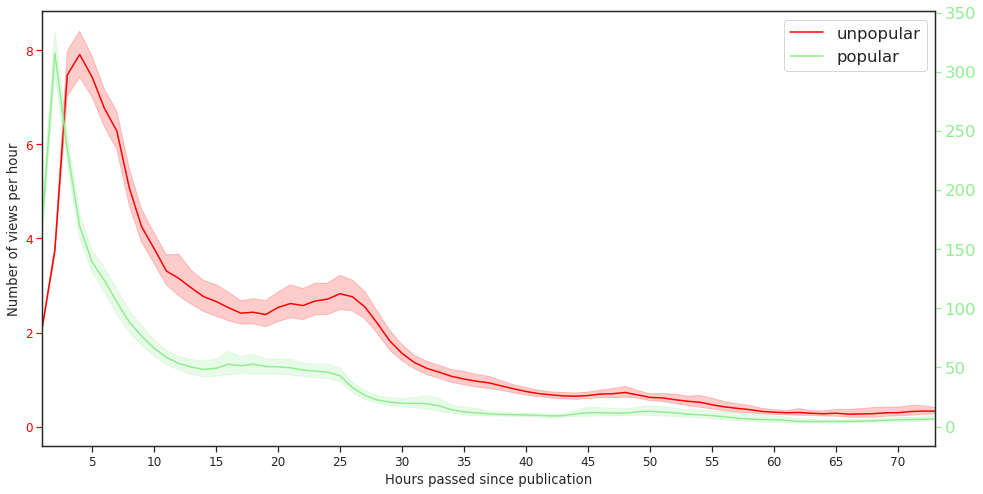

In [198]:
#We plot the trajectories in a similar fashion as we did for the whole data.
#The only difference is that we now thus plot two seperate plots layered over each other.
#They will both have a different axis, given that popular articles get logically a lot more views than impopular ones.
fig, ax = plt.subplots(figsize=(16,8))

sns.set(style="ticks", font_scale=1.5, palette="bright")

sns.lineplot(data=unpopular, color="red", x="Hours_passed", y="Views", label="unpopular")

ax2 = ax.twinx()

sns.lineplot(data=popular, color="lightgreen", x="Hours_passed", y="Views", label="popular")

ax.set_xlabel("Hours passed since publication")
ax.set_ylabel("Number of views per hour")
ax2.set_ylabel("")

ax.set_xticks(np.arange(0,73,5))
ax.set_xlim(1,73)

ax.tick_params(axis="y", colors="red")
ax2.tick_params(axis="y", colors="lightgreen")

plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

ax.get_legend().remove()
ax2.get_legend().remove()

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.savefig("Hours passed x Number of views x Popularity.pdf", format="pdf", bbox_inches="tight")

In [199]:
#We describe shelf-life per popularity dummy group.
df_1.groupby("Popularity")["Shelf_life"].describe()

count        mean         std  min   25%   50%    75%     max
Popularity                                                                 
False       43458.0  177.515371  333.689010  1.0   7.0  36.0  152.0  2115.0
True         3092.0   41.195019   61.759616  2.0  22.0  29.0   45.0  1317.0

In [200]:
#We create function that performs the Mann–Whitney U test.
def report_mwutest(listx, listy):
    #We again create objects for the unique (2) values of the dummy.
    cat1 = listx.unique()[0]
    cat2 = listx.unique()[1]
    
    #We create two empty lists.
    group1 = []
    group2 = []
    
    #We loop over the x and y values.
    for x,y in zip(listx, listy):
        #If x equals the first category it gets appended to that list.
        if x == cat1:
            group1.append(y)
        #If it equals the second category it gets appended to that list.
        elif x == cat2:
            group2.append(y)
            
    #The test is performed.
    Z, p = stats.mannwhitneyu(group1, group2)
    
    #The formatted results are printed.
    print(f"Mann-Whitney U rank test\nZ: {Z:.2f}\np: {p:.3f}")

In [201]:
#The test is used for the popularity dummy and shelf-life.
report_mwutest(df_1["Popularity"], df_1["Shelf_life"])

Mann-Whitney U rank test
Z: 71517502.00
p: 0.000


In [202]:
#We also test Spearman Rho for views in the first 2 hours against shelf-life.
report_spearman(df_1["Views_in_1st_2h"], df_1["Shelf_life"])

rho: 0.14
df: 46548
p: 0.000


In [203]:
#We do the same but than for popularity rank in the first 2 hours.
report_spearman(df_1["Popularity_rank_in_1st_2h"], df_1["Shelf_life"])

rho: 0.31
df: 46548
p: 0.000


## Extra: Author x Total views

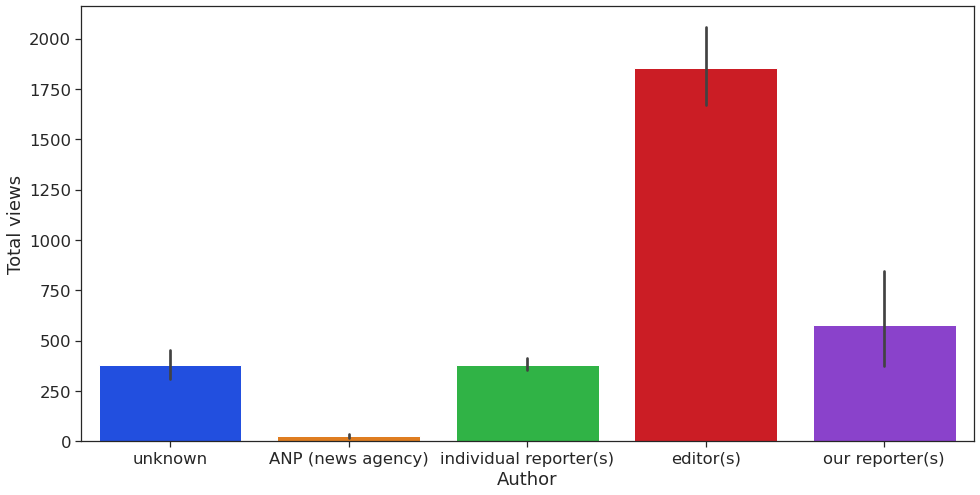

In [204]:
#We plot the author category against the total views.
fig, ax = plt.subplots(figsize=(16,8))

sns.set(style="ticks", font_scale=1.5, palette="bright")

sns.barplot(x="Author", y="Total_views", data=df_1, ax=ax)

ax.set_xlabel("Author")
ax.set_ylabel("Total views")

plt.savefig("Author x Total views.pdf", format="pdf", bbox_inches="tight")

In [205]:
#We describe total views per group.
df_1.groupby("Author")["Total_views"].describe()

count         mean          std  min   25%    50%  \
Author                                                                        
ANP (news agency)       19755.0    24.758643   844.159397  1.0   1.0    2.0   
editor(s)                1672.0  1854.234450  4055.982187  1.0  56.0  532.0   
individual reporter(s)  22898.0   381.243864  2345.781478  1.0   8.0   29.0   
our reporter(s)          1049.0   575.331745  4133.959629  1.0  10.0   28.0   
unknown                  1176.0   379.852041  1344.428962  1.0   4.0   14.0   

                            75%       max  
Author                                     
ANP (news agency)          4.00  102493.0  
editor(s)               1905.75   53136.0  
individual reporter(s)   150.00  220184.0  
our reporter(s)          128.00  112701.0  
unknown                   99.25   16285.0

In [206]:
#We create a function that performs an Anova (and others).
def report_anova(data, x, y):
    #The data is pivoted based on the categories in x and filled with the value of y.
    #This is than transformed into a nested list structure.
    lists = pd.pivot(data, columns=x, values=y).values.T.tolist()
    #Missing values are than filtered out.
    lists = [[i for i in l if pd.notna(i)] for l in lists]
    #The Levene's test is than performed on the list.
    F, p = stats.levene(*lists)
    print("Levene's Test")
    #The results are printed.
    print(tabulate([[F, p]], ["F", "p"], "simple"))

    print("\n")

    #An OLS is fitted.
    mod = ols(f"{y} ~ {x}", data=data).fit()
    
    #An ANOVA result is created.
    aov_table = sm.stats.anova_lm(mod, typ=2)
    #The Eta-Squared is calculated.
    esq_sm = aov_table["sum_sq"][0]/(aov_table["sum_sq"][0]+aov_table["sum_sq"][1])
    #And added to the result table.
    aov_table["EtaSq"] = [esq_sm, "NaN"]
    print("One-way ANOVA")
    
    #The results are printed.
    print(tabulate(aov_table, headers="keys"))

    print("\n")
    
    #The Kruskal-Wallis test is performed as well.
    H, p = stats.kruskal(*lists)
    print("Kruskal-Wallis test")
    print(tabulate([[H, p]], ["H", "p"], "simple"))

    print("\n")

    #A regular post hoc pairwise t-test is performed.
    pair_t = mod.t_test_pairwise(x)
    print("Pairwise T-Test")
    print(tabulate(pair_t.result_frame, headers="keys"))
    
    #As well as the Dunn's-version of it.
    print("\n")
    print("Dunn’s test")
    dunn = sp.posthoc_dunn(data, val_col=y, group_col=x)
    print(tabulate(dunn, headers="keys"))

In [207]:
report_anova(df_1, "Author", "Total_views")

Levene's Test
      F             p
-------  ------------
318.723  4.76338e-271


One-way ANOVA
               sum_sq     df        F          PR(>F)        EtaSq
--------  -----------  -----  -------  --------------  -----------
Author    5.76609e+09      4  357.662    7.23575e-304    0.0298203
Residual  1.87595e+11  46545  nan      nan             nan


Kruskal-Wallis test
      H    p
-------  ---
22806.5    0


Pairwise T-Test
                                                 coef    std err            t         P>|t|    Conf. Int. Low    Conf. Int. Upp.    pvalue-hs  reject-hs
----------------------------------------  -----------  ---------  -----------  ------------  ----------------  -----------------  -----------  -----------
editor(s)-ANP (news agency)                1829.48       51.1327   35.779      1.34768e-276         1729.26            1929.7     0            True
individual reporter(s)-ANP (news agency)    356.485      19.4945   18.2865     1.93553e-74           318.276 

## Extra: Inline media x Total views

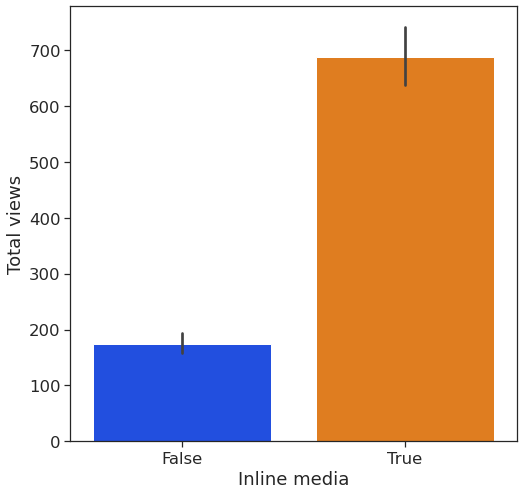

In [208]:
#We plot inline media dummy against total views.
fig, ax = plt.subplots(figsize=(8,8))

sns.set(style="ticks", font_scale=1.5, palette="bright")

sns.barplot(x="Inline_media", y="Total_views", data=df_1, ax=ax)

ax.set_xlabel("Inline media")
ax.set_ylabel("Total views")

plt.savefig("Inline media x Total views.pdf", format="pdf", bbox_inches="tight")

In [209]:
#We describe total views per group.
df_1.groupby("Inline_media")["Total_views"].describe()

count        mean          std  min   25%   50%    75%  \
Inline_media                                                             
False         36288.0  173.824928  1791.625933  1.0   1.0   5.0   27.0   
True          10262.0  688.128922  2699.352959  1.0  10.0  44.0  328.0   

                   max  
Inline_media            
False         220184.0  
True          122780.0

In [210]:
#We performt a t-test on it.
report_ttest(df_1["Inline_media"], df_1["Total_views"])

Levene's test
F: 492.43
p: 0.000
Independent t-test
t: -22.69
df: 46548
p: 0.000
Welch´s t-test
t: -18.20
df: 46548
p: 0.000


## Extra: Paid content x hours & shelf-life

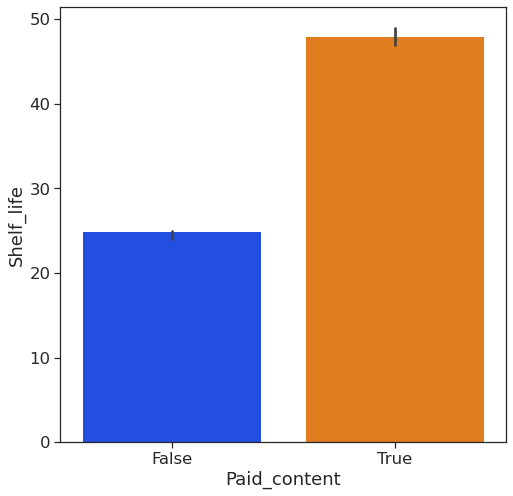

In [211]:
#We plot shelf-life for both paid content dummy categories.
fig, ax = plt.subplots(figsize=(8,8))

sns.set(style="ticks", font_scale=1.5, palette="bright")

sns.barplot(x="Paid_content", y="Shelf_life", data=df_1, ax=ax, estimator=np.median)

plt.savefig("Shelf-life x Paid content.pdf", format="pdf", bbox_inches="tight")

In [212]:
#We describe it per group.
df_1.groupby("Paid_content")["Shelf_life"].describe()

count        mean         std  min   25%   50%    75%     max
Paid_content                                                                 
False         28338.0  155.534477  317.883074  1.0   2.0  25.0  120.0  2112.0
True          18212.0  188.573578  333.770219  1.0  25.0  48.0  159.0  2115.0

In [213]:
#And perform a Mann-Whitney U test on it.
report_mwutest(df_1["Paid_content"], df_1["Shelf_life"])

Mann-Whitney U rank test
Z: 325486169.00
p: 0.000


### Extra: Day of the week x Total views

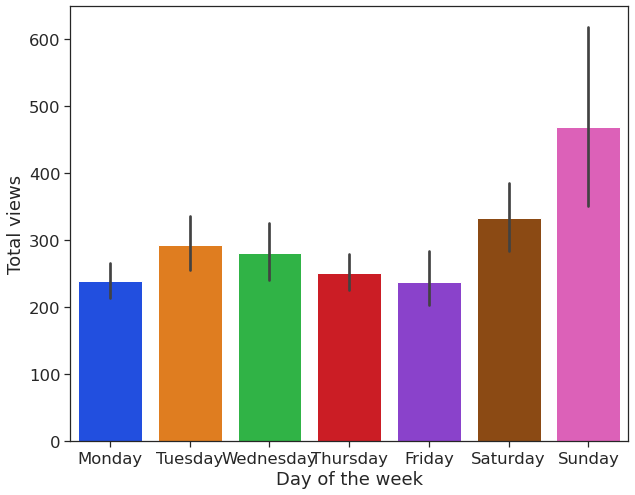

In [214]:
#We plot the total views per day of the week category.
fig, ax = plt.subplots(figsize=(10,8))

sns.set(style="ticks", font_scale=1.5, palette="bright")

sns.barplot(x="Day_of_the_week", y="Total_views", data=df_1, ax=ax, order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

ax.set_xlabel("Day of the week")
ax.set_ylabel("Total views")

plt.savefig("Day of the week x Total views.pdf", format="pdf", bbox_inches="tight")

In [215]:
#We describe total views per day of the week category.
df_1.groupby("Day_of_the_week")["Total_views"].describe()

count        mean          std  min  25%  50%   75%  \
Day_of_the_week                                                         
Friday           7964.0  237.848694  1808.243836  1.0  2.0  6.0  41.0   
Monday           6885.0  239.801743  1153.290341  1.0  2.0  8.0  55.0   
Saturday         5297.0  333.124788  1812.809970  1.0  2.0  9.0  51.0   
Sunday           4126.0  468.920504  4371.533038  1.0  2.0  8.0  66.0   
Thursday         7356.0  251.798260  1192.961670  1.0  2.0  8.0  52.0   
Tuesday          7272.0  292.358911  1688.875870  1.0  2.0  8.0  58.0   
Wednesday        7650.0  280.586405  1998.022042  1.0  2.0  8.0  49.0   

                      max  
Day_of_the_week            
Friday           122780.0  
Monday            24996.0  
Saturday          49698.0  
Sunday           220184.0  
Thursday          23913.0  
Tuesday           53136.0  
Wednesday        102493.0

In [216]:
#We report the ANOVA results.
report_anova(df_1, "Day_of_the_week", "Total_views")

Levene's Test
      F            p
-------  -----------
7.69176  2.78964e-08


One-way ANOVA
                      sum_sq     df          F         PR(>F)          EtaSq
---------------  -----------  -----  ---------  -------------  -------------
Day_of_the_week  1.92034e+08      6    7.71157    2.64183e-08    0.000993135
Residual         1.93169e+11  46543  nan        nan            nan


Kruskal-Wallis test
      H            p
-------  -----------
54.7696  5.15958e-10


Pairwise T-Test
                          coef    std err           t        P>|t|    Conf. Int. Low    Conf. Int. Upp.    pvalue-hs  reject-hs
------------------  ----------  ---------  ----------  -----------  ----------------  -----------------  -----------  -----------
Monday-Friday          1.95305    33.5253   0.0582559  0.953545             -63.7571           67.6632   0.988424     False
Saturday-Friday       95.2761     36.1201   2.63776    0.00834845            24.4801          166.072    0.118167     False


### Extra: Time of the day x Views per hour

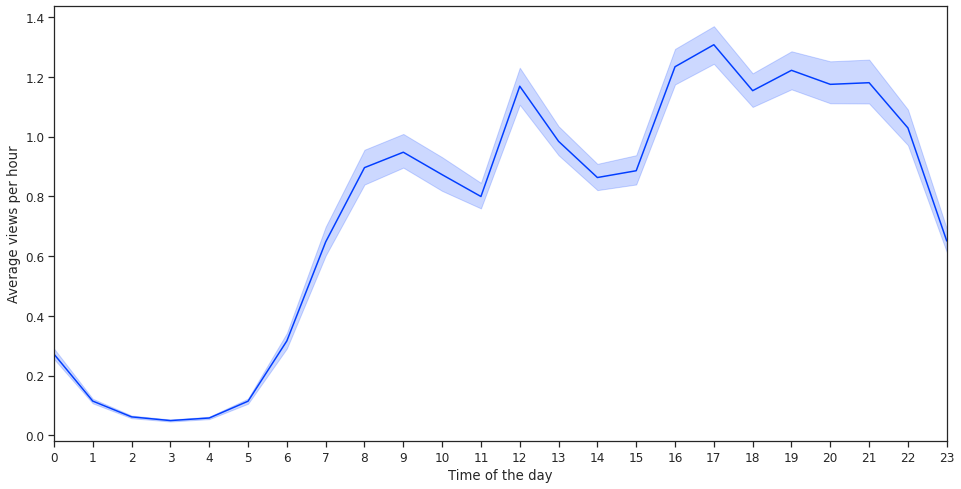

In [259]:
#We plot the views per hour of the day.
fig, ax = plt.subplots(figsize=(16,8))

sns.set(style="ticks", font_scale=1.1, palette="bright")

sns.lineplot(x="Time_of_the_day_num", y="Views", data=df, ax=ax)

ax.set_xlabel("Time of the day")
ax.set_ylabel("Average views per hour")

ax.set_xticks(np.arange(0,24,1))
ax.set_xlim(0,23)

plt.savefig("Time of the day x Number of views.pdf", format="pdf", bbox_inches="tight")

## Regression models

In [1791]:
#We load in extra libraries for the regression models.
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [1747]:
#We plot a correlation plot.
fig = plt.figure(figsize=(36,36), dpi = 480)
sns.heatmap(df_1.corr(), annot = True, fmt = '.2f')
plt.show()

In [1748]:
#We look at all the columns.
df_1.columns

Index(['Newspaper', 'Landing_page', 'Author', 'Background', 'Character_count',
       'Culture', 'Day_of_the_week', 'Domestic', 'Foreign', 'Frontpage',
       'Half_life', 'Highlighted', 'Hours_passed', 'Hours_till_peak',
       'Inline_media', 'Lifestyle', 'Number_of_sections_excl_frontpage',
       'Number_of_sections_incl_frontpage', 'Opinion', 'Paid_content',
       'Popularity', 'Popularity_rank', 'Popularity_rank_in_1st_2h',
       'Publication_date', 'Recommended', 'Regional', 'Section_trees',
       'Shelf_life', 'Slope_after_peak', 'Slope_before_peak', 'Sport',
       'Time_of_the_day_num', 'Timestamp_date', 'Total_views', 'Views',
       'Views_in_1st_2h', 'Time_of_the_day'],
      dtype='object')

In [1749]:
#We create a list of all our predictors.

base_predictors = "Newspaper +\
                   Author +\
                   Day_of_the_week +\
                   Time_of_the_day +\
                   Culture +\
                   Domestic +\
                   Foreign +\
                   Lifestyle +\
                   Opinion +\
                   Regional +\
                   Sport +\
                   Inline_media +\
                   Paid_content"

key_predictros = "Frontpage +\
                  Recommended +\
                  Highlighted +\
                  Background +\
                  Character_count +\
                  Number_of_sections_excl_frontpage +\
                  Popularity_rank_in_1st_2h +\
                  Views_in_1st_2h"

predictors = "Newspaper +\
              Author +\
              Background +\
              Character_count +\
              Culture +\
              Day_of_the_week +\
              Domestic +\
              Foreign +\
              Frontpage +\
              Highlighted +\
              Inline_media +\
              Lifestyle +\
              Number_of_sections_excl_frontpage +\
              Opinion +\
              Paid_content +\
              Popularity_rank_in_1st_2h +\
              Recommended +\
              Regional +\
              Sport +\
              Time_of_the_day +\
              Views_in_1st_2h"

base_and_key_predictors = base_predictors + " + " + key_predictros

## Cox Proportional Hazards on Shelf-life

In [21]:
from sksurv.datasets import load_whas500
from sksurv.linear_model import CoxPHSurvivalAnalysis

In [41]:
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi

rossi = load_rossi()

cph = CoxPHFitter()
cph.fit(rossi, duration_col='week')

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 432 total observations, 0 right-censored observations>
             duration col = 'week'
      baseline estimation = breslow
   number of observations = 432
number of events observed = 432
   partial log-likelihood = -2047.24
         time fit was run = 2024-03-19 09:41:32 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
arrest      2.65      14.22       0.14             2.38             2.93                10.76                18.79
fin         0.17       1.18       0.10            -0.03             0.36                 0.97                 1.44
age        -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
race        0.17       1.18       0.15            -0.12             0.46                 0.88                 1.58
wexp       -0.15       0.86       0.11            -0.36             0.07                 0.69                 1.07
mar         0.11       1.12       0.15            -0.19             0.41                 0.83                 1.51
paro        0.09       1.09       0.10            -0.11             0.29                 0.90                 1.33
prio        0.04       1.04       0.02             0.00             0.07                 1.00                 1.07

            cmp to     z      p   -log2(p)
covariate                                 
arrest        0.00 18.66 <0.005     255.81
fin           0.00  1.63   0.10       3.29
age           0.00 -0.15   0.88       0.18
race          0.00  1.13   0.26       1.95
wexp          0.00 -1.33   0.18       2.45
mar           0.00  0.72   0.47       1.08
paro          0.00  0.87   0.38       1.38
prio          0.00  2.18   0.03       5.10
---
Concordance = 0.93
Partial AIC = 4110.47
log-likelihood ratio test = 292.55 on 8 df
-log2(p) of ll-ratio test = 192.01

<lifelines.CoxPHFitter: fitted with 46550 total observations, 0 right-censored observations>
             duration col = 'Shelf_life'
      baseline estimation = breslow
   number of observations = 46550
number of events observed = 46550
   partial log-likelihood = -450207.65
         time fit was run = 2024-03-19 10:37:08 UTC

---
                                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                 
Background                         -0.25       0.78       0.04            -0.33            -0.17                 0.72                 0.85
Character_count                    -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
Culture                            -0.16       0.85       0.06            -0.27            -0.05                 0.76                 0.95
Domestic                            0.18       1.19       0.04             0.09             0.26                 1.10                 1.30
Foreign                             0.24       1.27       0.04             0.15             0.32                 1.16                 1.38
Frontpage                           0.21       1.23       0.01             0.18             0.24                 1.20                 1.27
Highlighted                         0.09       1.09       0.03             0.03             0.14                 1.03                 1.15
Inline_media                        0.01       1.01       0.01            -0.01             0.04                 0.99                 1.04
Lifestyle                          -0.22       0.81       0.04            -0.30            -0.13                 0.74                 0.88
Number_of_sections_excl_frontpage   0.15       1.17       0.02             0.11             0.20                 1.11                 1.22
Opinion                            -0.10       0.91       0.04            -0.17            -0.02                 0.84                 0.98
Paid_content                        0.08       1.08       0.02             0.05             0.11                 1.05                 1.11
Popularity_rank_in_1st_2h          -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
Recommended                        -0.35       0.71       0.07            -0.48            -0.21                 0.62                 0.81
Regional                           -0.11       0.89       0.03            -0.17            -0.06                 0.85                 0.95
Sport                              -0.16       0.85       0.03            -0.21            -0.11                 0.81                 0.90
Time_of_the_day                     0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Views_in_1st_2h                     0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
Newspaper_Haarlemsdagblad          -0.38       0.68       0.02            -0.41            -0.34                 0.66                 0.71
Newspaper_Ijmuidercourant           0.14       1.15       0.02             0.11             0.17                 1.11                 1.18
Newspaper_Leidschdagblad           -0.21       0.81       0.02            -0.24            -0.17                 0.79                 0.84
Newspaper_Noordhollandsdagblad     -0.44       0.64       0.02            -0.48            -0.41                 0.62                 0.67
Author_editor(s)                    0.01       1.01       0.04            -0.07             0.10                 0.93                 1.10
Author_individual reporter(s)      -0.16       0.86       0.04            -0.23            -0.09                 0.80                 0.92
Author_our reporter(s)             -0.17       0.85 

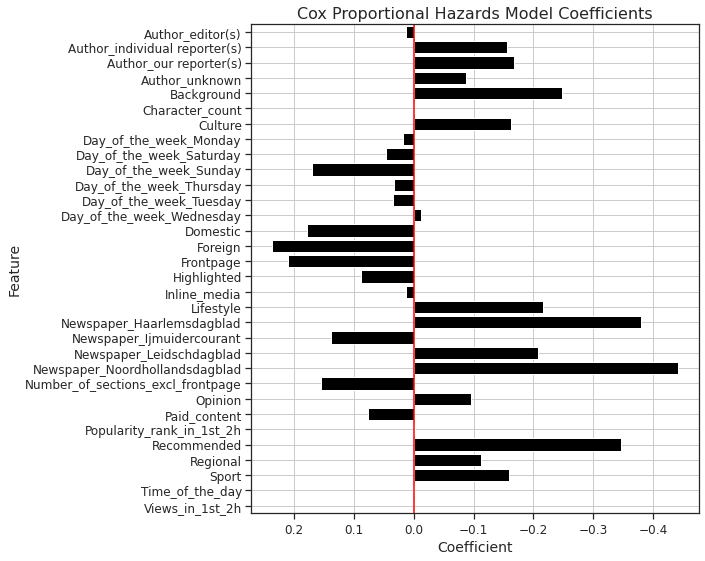

In [106]:
df_1_Cox = df_1[["Newspaper", "Author", "Background", "Character_count", "Culture", "Day_of_the_week", 
                 "Domestic", "Foreign", "Frontpage", "Highlighted", "Inline_media", "Lifestyle", ""
                 "Number_of_sections_excl_frontpage", "Opinion", "Paid_content", "Popularity_rank_in_1st_2h", 
                 "Recommended", "Regional", "Sport", "Time_of_the_day", "Views_in_1st_2h", "Shelf_life"]]

df_1_Cox = pd.get_dummies(df_1_Cox, columns=["Newspaper", "Author", "Day_of_the_week"], drop_first=True)
bool_col = ["Background", "Culture", "Domestic", "Foreign", "Frontpage", "Highlighted", "Inline_media", "Lifestyle", "Opinion", "Paid_content", "Recommended", "Regional", "Sport"]
df_1_Cox[bool_col] = df_1_Cox[bool_col].astype(int)

cph = CoxPHFitter()
cph.fit(df_1_Cox, duration_col='Shelf_life')

cph.print_summary()

coefficients = cph.summary
coefficients = coefficients[coefficients.index != 'baseline'] 
coefficients = coefficients.sort_index()  

plt.figure(figsize=(10, 8))

sns.barplot(x='coef', y=coefficients.index, data=coefficients, color="black")
sns.set(style="ticks", font_scale=1.1)
plt.xlabel('Coefficient', fontsize=14)  
plt.ylabel('Feature', fontsize=14)    
plt.title('Cox Proportional Hazards Model Coefficients', fontsize=16)  
plt.tight_layout()
plt.gca().invert_xaxis() 
plt.grid(True)
plt.axvline(x=0, color='red')
plt.show()

## Linear Regression Model (LRM) on Total Views

In [1778]:
def get_OLS_output(dep, data):
    
    coef_tables = []
    statistics_list = []

    for pred in [base_predictors, base_and_key_predictors]:
        md = smf.ols(f"{dep} ~ {pred}", data)
        mdf = md.fit()
        summary = mdf.summary2(); print(summary)
        coef_table = pd.DataFrame(summary.tables[1])
        index = coef_table.index
        coef_table = coef_table.iloc[:, [0, 1, 3]]
        coef_table = coef_table.set_index(coef_table.iloc[:, 0]).iloc[:, 1:].reset_index()
        coef_tables.append(coef_table)
        
        statistics = ['{0:.0f}'.format(int(mdf.nobs)), 
                      '{0:.2f}'.format(round(mdf.rsquared, 2)), 
                      '{0:.2f}'.format(round(mdf.rsquared_adj, 2)), 
                      '{0:.2f}'.format(round(mdf.fvalue, 2))]
        statistics_list.append(statistics)

    coef_tables = pd.concat([coef_tables[0], coef_tables[1]], axis=1)
    coef_tables.insert(0, " ", index.tolist())
    coef_tables[["Coef."]] = coef_tables[["Coef."]].applymap(lambda x: '{0:.2f}'.format(round(float(x), 2)))
    coef_tables[["Std.Err."]] = coef_tables[["Std.Err."]].applymap(lambda x: '{0:.2f}'.format(round(float(x), 2)))
    coef_tables[["P>|t|"]] = coef_tables[["P>|t|"]].applymap(lambda x: '{0:.3f}'.format(round(float(x), 3)))
    
    coef_tables_w_stats = []
    coef_tables_split = [coef_tables.iloc[:,:4], coef_tables.iloc[:,4:]]
    
    for t, stats in zip(coef_tables_split, statistics_list):
        for s in stats:
            t = t.append({"Coef.":np.nan, "Std.Err.":np.nan, "P>|t|": s}, ignore_index=True)
        coef_tables_w_stats.append(t)
        
    coef_tables = pd.concat([coef_tables_w_stats[0], coef_tables_w_stats[1]], axis=1)
    
    coef_tables.loc[len(index), " "] = "Obs."
    coef_tables.loc[len(index) + 1, " "] = "R_squared"
    coef_tables.loc[len(index) + 2, " "] = "R_squared_adj."
    coef_tables.loc[len(index) + 3, " "] = "F_statistic"
    
    latex = coef_tables.to_latex(index=False, na_rep=" ", column_format="lrrrrrr")
    latex = latex.replace('Coef.', '$B$').replace('Std.Err.', '$se$').replace('P>|t|', '$p$').replace("nan", " ")
    latex = latex.split("Obs.")[0] + "\\midrule Obs." + latex.split("Obs.")[1]
    latex = latex.replace('Obs.', '$N$').replace('R\_squared\_adj.', '$R^{2}_{adj}$').replace('R\_squared', '$R^{2}$').replace("F\_statistic", "$F$")
    print("\n", latex)
    
    coef_tables2 = coef_tables.copy()
    coef_tables2, coef_tables2_stat = coef_tables2.iloc[:-4,], coef_tables2.iloc[-4:,[0, 3, 6]]
    coef_tables2[" "] = coef_tables2[" "].apply(lambda x: "BF " + x + " BE")
    coef_tables2[["P>|t|"]] = coef_tables2[["P>|t|"]].applymap(lambda x: get_stars(x))
    
    coef_tables2['Base model'] = coef_tables2.iloc[:, 1].astype(str) + " (" +\
                                 coef_tables2.iloc[:, 2].astype(str) + ") " +\
                                 coef_tables2.iloc[:, 3].astype(str) 

    coef_tables2['Theoretical model'] = coef_tables2.iloc[:, 4].astype(str) + " (" +\
                                        coef_tables2.iloc[:, 5].astype(str) + ") " +\
                                        coef_tables2.iloc[:, 6].astype(str)
    
    coef_tables2["Base model"] = coef_tables2["Base model"].apply(lambda x: x.replace("nan (nan) None", ""))
    coef_tables2 = coef_tables2.iloc[:, [0, -2, -1]]
    coef_tables2.columns = [" ", "BF Base model BE", "BF Theoretical model BE"]
    coef_tables2_stat.columns = [" ", "BF Base model BE", "BF Theoretical model BE"]
    coef_tables2 = pd.concat([coef_tables2, coef_tables2_stat], ignore_index=True)

    latex2 = coef_tables2.to_latex(index=False, na_rep=" ", column_format="lrr")
    latex2 = latex2.split("Obs.")[0] + "\\midrule Obs." + latex2.split("Obs.")[1]
    latex2 = latex2.replace('BF ', '\\textbf{').replace(' BE', '}')
    latex2 = latex2.replace('Obs.', '$N$').replace('R\_squared\_adj.', '$R^{2}_{adj}$').replace('R\_squared', '$R^{2}$').replace("F\_statistic", "$F$")
    print("\n", latex2)
    
    return coef_tables2

In [1779]:
coef_tables = get_OLS_output(dep="Total_views", data=df_1)

                            Results: Ordinary least squares
Model:                      OLS                    Adj. R-squared:           0.040      
Dependent Variable:         Total_views            AIC:                      839611.7215
Date:                       2024-05-05 15:23       BIC:                      839874.1700
No. Observations:           46550                  Log-Likelihood:           -4.1978e+05
Df Model:                   29                     F-statistic:              68.71      
Df Residuals:               46520                  Prob (F-statistic):       0.00       
R-squared:                  0.041                  Scale:                    3.9858e+06 
----------------------------------------------------------------------------------------
                                     Coef.   Std.Err.    t    P>|t|    [0.025    0.975] 
----------------------------------------------------------------------------------------
Intercept                           380.6434  92.9

#We run an OLS model, predicting total views.
md = smf.ols(f"Total_views ~ {predictors}", df_1)
#We fit it.
mdf = md.fit()
#We print the summary.
print(mdf.summary())

#We transform the summary to latex (for our paper).
summary = mdf.summary()
print(summary.as_latex())

In [263]:
def plot_coeff(model=mdf, title="Effect on views"):
    coef_df = pd.DataFrame({"name": model.params.index[1:], "se": model.bse.values[1:], "estimate": model.params.values[1:]})
    fig, ax = plt.subplots(figsize=(8, 12))
    sns.set(style="ticks", font_scale=1.1, palette="Set1")

    y_pos = np.arange(len(coef_df.name.values))

    ax.barh(y_pos, coef_df["estimate"], xerr=coef_df["se"], align="center", height=1, color="lightgrey")
    ax.set_yticks(y_pos)
    ax.set_yticklabels(coef_df["name"])
    ax.axvline(x=0, linestyle="--", color="red", linewidth=1)
    ax.invert_yaxis() 
    ax.set_title(title)

    ax.grid(True)

    plt.savefig(f"{title}.pdf", format="pdf", bbox_inches="tight")
    
    plt.show()

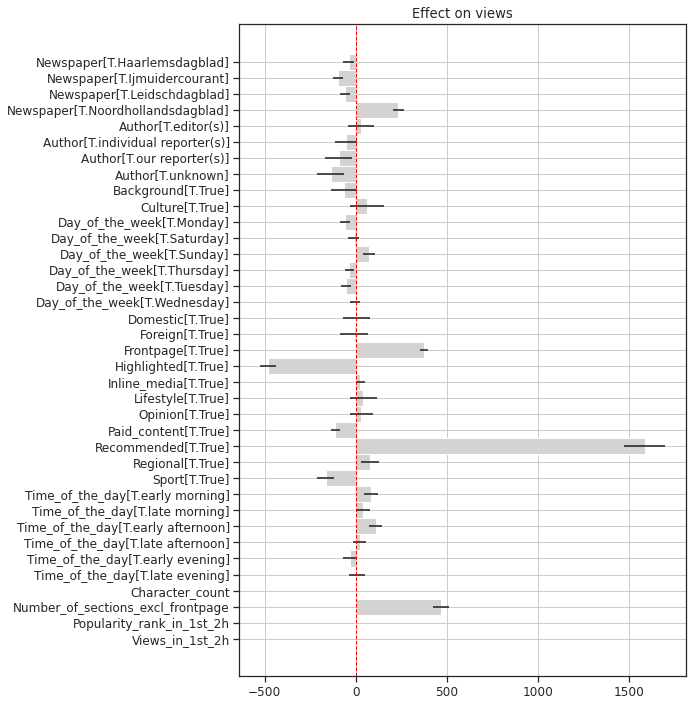

In [264]:
plot_coeff(model=mdf)

## Poisson Regression Model (PRM) on Total Views

#We create a GLM assuming a Poisson distribution. 
md = smf.glm(f"Total_views ~ {predictors}", df_1, family=sm.families.NegativeBinomial())
#We fit it.
mdf = md.fit()
#We print the summary.
print(mdf.summary())

In [1816]:
def get_Poisson_output(dep, data):
    
    coef_tables = []
    statistics_list = []

    for pred in [base_predictors, base_and_key_predictors]:
        md = smf.glm(f"{dep} ~ {pred}", data, family=sm.families.Poisson())
        mdf = md.fit()
        summary = mdf.summary2(); print(summary)
        coef_table = pd.DataFrame(summary.tables[1])
        index = coef_table.index
        coef_table = coef_table.iloc[:, [0, 1, 3]]
        coef_table = coef_table.set_index(coef_table.iloc[:, 0]).iloc[:, 1:].reset_index()
        coef_tables.append(coef_table)
        
        statistics = ['{0:.0f}'.format(int(mdf.nobs)), 
                      '{0:.2f}'.format(round(mdf.aic, 2)), 
                      '{0:.2f}'.format(round(mdf.bic, 2)), 
                      '{0:.2f}'.format(round(mdf.llf, 2))]
        statistics_list.append(statistics)

    coef_tables = pd.concat([coef_tables[0], coef_tables[1]], axis=1)
    coef_tables.insert(0, " ", index.tolist())
    coef_tables[["Coef."]] = coef_tables[["Coef."]].applymap(lambda x: '{0:.2f}'.format(round(float(x), 2)))
    coef_tables[["Std.Err."]] = coef_tables[["Std.Err."]].applymap(lambda x: '{0:.2f}'.format(round(float(x), 2)))
    coef_tables[["P>|z|"]] = coef_tables[["P>|z|"]].applymap(lambda x: '{0:.3f}'.format(round(float(x), 3)))
    
    coef_tables_w_stats = []
    coef_tables_split = [coef_tables.iloc[:,:4], coef_tables.iloc[:,4:]]
    
    for t, stats in zip(coef_tables_split, statistics_list):
        for s in stats:
            t = t.append({"Coef.":np.nan, "Std.Err.":np.nan, "P>|z|": s}, ignore_index=True)
        coef_tables_w_stats.append(t)
        
    coef_tables = pd.concat([coef_tables_w_stats[0], coef_tables_w_stats[1]], axis=1)
    
    coef_tables.loc[len(index), " "] = "Obs."
    coef_tables.loc[len(index) + 1, " "] = "AIC_statistic"
    coef_tables.loc[len(index) + 2, " "] = "BIC_statistic"
    coef_tables.loc[len(index) + 3, " "] = "LL_statistic"
    
    latex = coef_tables.to_latex(index=False, na_rep=" ", column_format="lrrrrrr")
    latex = latex.replace('Coef.', '$B$').replace('Std.Err.', '$se$').replace('P>|z|', '$p$').replace("nan", " ")
    latex = latex.split("Obs.")[0] + "\\midrule Obs." + latex.split("Obs.")[1]
    latex = latex.replace('Obs.', '$N$').replace("AIC\_statistic", "$AIC$").replace("BIC\_statistic", "$BIC$").replace("LL\_statistic", "$LL$")
    print("\n", latex)
    
    coef_tables2 = coef_tables.copy()
    coef_tables2, coef_tables2_stat = coef_tables2.iloc[:-4,], coef_tables2.iloc[-4:,[0, 3, 6]]
    coef_tables2[" "] = coef_tables2[" "].apply(lambda x: "BF " + x + " BE")
    coef_tables2[["P>|z|"]] = coef_tables2[["P>|z|"]].applymap(lambda x: get_stars(x))
    
    coef_tables2['Base model'] = coef_tables2.iloc[:, 1].astype(str) + " (" +\
                                 coef_tables2.iloc[:, 2].astype(str) + ") " +\
                                 coef_tables2.iloc[:, 3].astype(str) 

    coef_tables2['Theoretical model'] = coef_tables2.iloc[:, 4].astype(str) + " (" +\
                                        coef_tables2.iloc[:, 5].astype(str) + ") " +\
                                        coef_tables2.iloc[:, 6].astype(str)
    
    coef_tables2["Base model"] = coef_tables2["Base model"].apply(lambda x: x.replace("nan (nan) None", ""))
    coef_tables2 = coef_tables2.iloc[:, [0, -2, -1]]
    coef_tables2.columns = [" ", "BF Base model BE", "BF Theoretical model BE"]
    coef_tables2_stat.columns = [" ", "BF Base model BE", "BF Theoretical model BE"]
    coef_tables2 = pd.concat([coef_tables2, coef_tables2_stat], ignore_index=True)

    latex2 = coef_tables2.to_latex(index=False, na_rep=" ", column_format="lrr")
    latex2 = latex2.split("Obs.")[0] + "\\midrule Obs." + latex2.split("Obs.")[1]
    latex2 = latex2.replace('BF ', '\\textbf{').replace(' BE', '}')
    latex2 = latex2.replace('Obs.', '$N$').replace("AIC\_statistic", "$AIC$").replace("BIC\_statistic", "$BIC$").replace("LL\_statistic", "$LL$")
    print("\n", latex2)
    
    return coef_tables2

In [1815]:
coef_tables = get_Poisson_output(dep="Total_views", data=df_1)

                          Results: Generalized linear model
Model:                     GLM                    AIC:                  44985019.7975
Link Function:             log                    BIC:                  44279401.9784
Dependent Variable:        Total_views            Log-Likelihood:       -2.2492e+07  
Date:                      2024-05-05 16:06       LL-Null:              -3.4475e+07  
No. Observations:          46550                  Deviance:             4.4779e+07   
Df Model:                  29                     Pearson chi2:         3.23e+08     
Df Residuals:              46520                  Scale:                1.0000       
Method:                    IRLS                                                      
-------------------------------------------------------------------------------------
                                    Coef.  Std.Err.     z      P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------

/opt/conda/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1721: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  @cached_data


                          Results: Generalized linear model
Model:                     GLM                    AIC:                  22540843.8169
Link Function:             log                    BIC:                  21835295.9840
Dependent Variable:        Total_views            Log-Likelihood:       -1.1270e+07  
Date:                      2024-05-05 16:06       LL-Null:              -3.4475e+07  
No. Observations:          46550                  Deviance:             2.2335e+07   
Df Model:                  37                     Pearson chi2:         6.35e+07     
Df Residuals:              46512                  Scale:                1.0000       
Method:                    IRLS                                                      
-------------------------------------------------------------------------------------
                                    Coef.  Std.Err.     z      P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------

/opt/conda/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1721: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  @cached_data


#We create a GLM assuming a Poisson distribution. 
md = smf.glm(f"Total_views ~ {predictors}", df_1, family=sm.families.Poisson())
#We fit it.
mdf = md.fit()
#We print the summary.
print(mdf.summary())

#We transform the summary to latex (for our paper).
summary = mdf.summary()
print(summary.as_latex())

## RLM on Total Views

In [268]:
#We run a robust linear model for total views.
md = smf.rlm(f"Total_views ~ {predictors}", df_1)
mdf = md.fit()
print(mdf.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:            Total_views   No. Observations:                46550
Model:                            RLM   Df Residuals:                    46512
Method:                          IRLS   Df Model:                           37
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 01 May 2024                                         
Time:                        12:51:08                                         
No. Iterations:                    50                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [269]:
summary = mdf.summary()
print(summary.as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                        &   Total\_views   & \textbf{  No. Observations:  } &    46550    \\
\textbf{Model:}                                &       RLM        & \textbf{  Df Residuals:      } &    46512    \\
\textbf{Method:}                               &       IRLS       & \textbf{  Df Model:          } &       37    \\
\textbf{Norm:}                                 &      HuberT      & \textbf{                     } &             \\
\textbf{Scale Est.:}                           &       mad        & \textbf{                     } &             \\
\textbf{Cov Type:}                             &        H1        & \textbf{                     } &             \\
\textbf{Date:}                                 & Wed, 01 May 2024 & \textbf{                     } &             \\
\textbf{Time:}                                 &     12:51:08     & \textbf{                     } &             \\
\bottomrule
\end{tabular}


## Linear Regression Model on Shelf-life

In [1780]:
coef_tables = get_OLS_output(dep="Shelf_life", data=df_1)

                           Results: Ordinary least squares
Model:                    OLS                    Adj. R-squared:           0.065      
Dependent Variable:       Shelf_life             AIC:                      667354.4156
Date:                     2024-05-05 15:29       BIC:                      667616.8641
No. Observations:         46550                  Log-Likelihood:           -3.3365e+05
Df Model:                 29                     F-statistic:              112.8      
Df Residuals:             46520                  Prob (F-statistic):       0.00       
R-squared:                0.066                  Scale:                    98496.     
--------------------------------------------------------------------------------------
                                    Coef.   Std.Err.    t     P>|t|   [0.025   0.975] 
--------------------------------------------------------------------------------------
Intercept                           97.1012  14.6130   6.6448 0.0000  6

#We also run the same models but than for shelf-life.
md = smf.ols(f"Shelf_life ~ {predictors}", df_1)
mdf = md.fit()
print(mdf.summary())

summary = mdf.summary()
print(summary.as_latex())

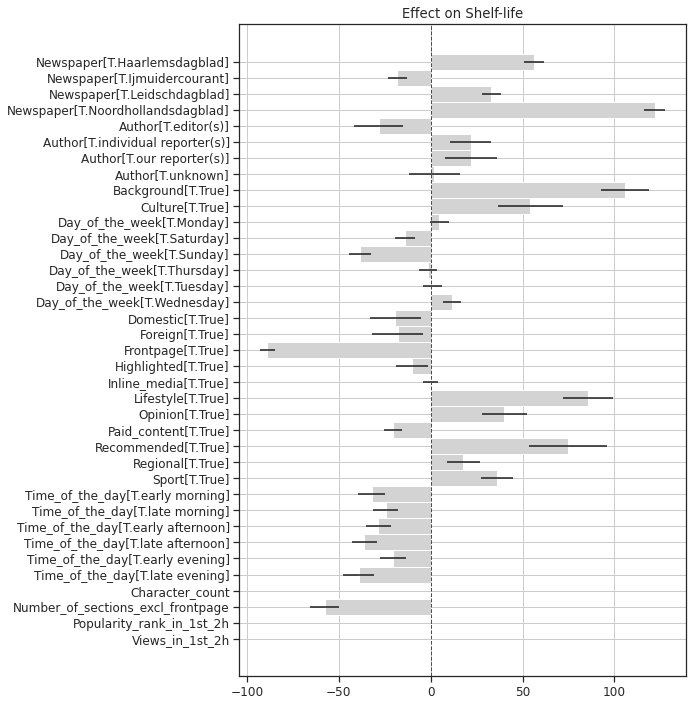

In [272]:
plot_coeff(model=mdf, title="Effect on Shelf-life")

## Poisson Regression Model (PRM) on Shelf-life

In [1817]:
coef_tables = get_Poisson_output(dep="Shelf_life", data=df_1)

                         Results: Generalized linear model
Model:                    GLM                    AIC:                  15990246.9173
Link Function:            log                    BIC:                  15241240.4882
Dependent Variable:       Shelf_life             Log-Likelihood:       -7.9951e+06  
Date:                     2024-05-05 16:11       LL-Null:              -8.9589e+06  
No. Observations:         46550                  Deviance:             1.5741e+07   
Df Model:                 29                     Pearson chi2:         2.69e+07     
Df Residuals:             46520                  Scale:                1.0000       
Method:                   IRLS                                                      
------------------------------------------------------------------------------------
                                    Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------------------
Interc

/opt/conda/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1721: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  @cached_data


                         Results: Generalized linear model
Model:                    GLM                    AIC:                  15367463.1150
Link Function:            log                    BIC:                  14618526.6722
Dependent Variable:       Shelf_life             Log-Likelihood:       -7.6837e+06  
Date:                     2024-05-05 16:11       LL-Null:              -8.9589e+06  
No. Observations:         46550                  Deviance:             1.5118e+07   
Df Model:                 37                     Pearson chi2:         7.34e+14     
Df Residuals:             46512                  Scale:                1.0000       
Method:                   IRLS                                                      
------------------------------------------------------------------------------------
                                    Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------------------
Interc

/opt/conda/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1721: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  @cached_data


In [273]:
md = smf.glm(f"Shelf_life ~ {predictors}", df_1, family=sm.families.Poisson())
mdf = md.fit()
print(mdf.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             Shelf_life   No. Observations:                46550
Model:                            GLM   Df Residuals:                    46512
Model Family:                 Poisson   Df Model:                           37
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -7.6837e+06
Date:                Wed, 01 May 2024   Deviance:                   1.5118e+07
Time:                        12:51:11   Pearson chi2:                 7.34e+14
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [274]:
summary = mdf.summary()
print(summary.as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                        &   Shelf\_life    & \textbf{  No. Observations:  } &     46550    \\
\textbf{Model:}                                &       GLM        & \textbf{  Df Residuals:      } &     46512    \\
\textbf{Model Family:}                         &     Poisson      & \textbf{  Df Model:          } &        37    \\
\textbf{Link Function:}                        &       log        & \textbf{  Scale:             } &     1.0000   \\
\textbf{Method:}                               &       IRLS       & \textbf{  Log-Likelihood:    } & -7.6837e+06  \\
\textbf{Date:}                                 & Wed, 01 May 2024 & \textbf{  Deviance:          } &  1.5118e+07  \\
\textbf{Time:}                                 &     12:51:11     & \textbf{  Pearson chi2:      } &   7.34e+14   \\
\textbf{No. Iterations:}                       &        7         & \textbf{                     } &              \\
\bottomrule
\end{t

## RLM on Shelf-life

In [275]:
md = smf.rlm(f"Shelf_life ~ {predictors}", df_1)
mdf = md.fit()
print(mdf.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:             Shelf_life   No. Observations:                46550
Model:                            RLM   Df Residuals:                    46512
Method:                          IRLS   Df Model:                           37
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 01 May 2024                                         
Time:                        12:51:14                                         
No. Iterations:                    32                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [276]:
summary = mdf.summary()
print(summary.as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                        &   Shelf\_life    & \textbf{  No. Observations:  } &    46550    \\
\textbf{Model:}                                &       RLM        & \textbf{  Df Residuals:      } &    46512    \\
\textbf{Method:}                               &       IRLS       & \textbf{  Df Model:          } &       37    \\
\textbf{Norm:}                                 &      HuberT      & \textbf{                     } &             \\
\textbf{Scale Est.:}                           &       mad        & \textbf{                     } &             \\
\textbf{Cov Type:}                             &        H1        & \textbf{                     } &             \\
\textbf{Date:}                                 & Wed, 01 May 2024 & \textbf{                     } &             \\
\textbf{Time:}                                 &     12:51:14     & \textbf{                     } &             \\
\bottomrule
\end{tabular}


## Transforming data for Mixed-effects modelling

In [1750]:
#We create an empty list.
unique = []

#We loop over the landing pages.
for item in tqdm(df_1["Landing_page"].values):
    #We check if the landing page only occurs once.
    #If so we append TRUE.
    if list(df_1["Landing_page"].values).count(item) == 1:
        unique.append(True)
    #If not we append FALSE, which would indicate that the article is published on multiple newspapers.
    else:
        unique.append(False)

100%|██████████| 46550/46550 [01:35<00:00, 488.58it/s]


In [1751]:
#We add it as a column.
df_1["Unique"] = unique
#And subset the data to only keep articles that are atleast published twice.
df_2 = df_1[df_1["Unique"] == False]
df_2.head()

Newspaper               Landing_page                  Author  \
0  Gooieneemlander  /cnt/dmf20190705_81476516                 unknown   
1  Gooieneemlander  /cnt/dmf20200501_53506347                 unknown   
2  Gooieneemlander  /cnt/dmf20201026_62507126       ANP (news agency)   
3  Gooieneemlander  /cnt/dmf20201113_84348583  individual reporter(s)   
4  Gooieneemlander  /cnt/dmf20201228_15837729       ANP (news agency)   

   Background  Character_count  Culture Day_of_the_week  Domestic  Foreign  \
0       False           3286.0    False       Wednesday     False    False   
1        True           1776.0    False          Monday     False    False   
2       False           1103.0    False        Thursday     False     True   
3       False           2261.0    False       Wednesday     False    False   
4       False           1410.0    False        Thursday      True    False   

   Frontpage  ...  Slope_after_peak  Slope_before_peak  Sport  \
0       True  ...          0.000000           0.176591  False   
1      False  ...         -0.190160                NaN  False   
2      False  ...          0.000000                NaN  False   
3      False  ...         -0.105842                NaN  False   
4      False  ...               NaN           2.000000  False   

   Time_of_the_day_num       Timestamp_date  Total_views  Views  \
0                   19  2021-05-26 19:00:00            3      0   
1                   18  2021-07-05 18:00:00           13      4   
2                   10  2021-04-22 10:00:00            2      1   
3                    8  2021-06-02 08:00:00            8      3   
4                   10  2021-06-10 10:00:00            1      0   

   Views_in_1st_2h  Time_of_the_day  Unique  
0                0    early evening   False  
1                5    early evening   False  
2                1     late morning   False  
3                3    early morning   False  
4                1     late morning   False  

[5 rows x 38 columns]

In [1752]:
#We write it away
df_2.to_csv("non_Unique_Publications.csv", index=False)

## Fixed-effects Regression Model (FERM) on Total views

In [1771]:
#We read the file back in.
df_2 = pd.read_csv("non_Unique_Publications.csv")

In [1773]:
order = ["night", "early morning", "late morning", "early afternoon", "late afternoon", "early evening", "late evening"]
df_2["Time_of_the_day"] = df_2.Time_of_the_day.astype("category").cat.reorder_categories(order, ordered=True)
order2 = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
df_2["Day_of_the_week"] = df_2.Day_of_the_week.astype("category").cat.reorder_categories(order2, ordered=True)

In [1774]:
def get_stars(x):
    try:
        x = float(x)
        if x < 0.01:
            return "***"
        elif x < 0.05:
            return "**"
        elif x < 0.10:
            return "*"
        elif x >= 0.10:
            return ""
    except Exception as e:
        print(e)
        return x

In [1775]:
def get_MLM_output(dep, data, groups):
    
    coef_tables = []
    statistics_list = []

    for pred in [base_predictors, base_and_key_predictors]:
        md = smf.mixedlm(f"{dep} ~ {pred}", data, groups=data[groups])
        mdf = md.fit()
        summary = mdf.summary(); print(summary)
        coef_table = pd.DataFrame(summary.tables[1]).iloc[:-1,:]
        index = coef_table.index
        coef_table = coef_table.iloc[:, [0, 1, 3]]
        coef_table = coef_table.set_index(coef_table.iloc[:, 0]).iloc[:, 1:].reset_index()
        coef_tables.append(coef_table)

        var_resid = mdf.scale
        var_random_effect = float(mdf.cov_re.iloc[0])
        var_fixed_effect = mdf.predict(df_2).var()

        total_var = var_fixed_effect + var_random_effect + var_resid
        marginal_r2 = var_fixed_effect / total_var
        conditional_r2 = (var_fixed_effect + var_random_effect) / total_var

        statistics = ['{0:.0f}'.format(int(mdf.nobs)), 
                      '{0:.2f}'.format(round(marginal_r2, 2)), 
                      '{0:.2f}'.format(round(conditional_r2, 2)), 
                      '{0:.2f}'.format(round(mdf.llf, 2))]
        statistics_list.append(statistics)

    coef_tables = pd.concat([coef_tables[0], coef_tables[1]], axis=1)
    coef_tables.insert(0, " ", index.tolist())
    coef_tables[["Coef."]] = coef_tables[["Coef."]].applymap(lambda x: '{0:.2f}'.format(round(float(x), 2)))
    coef_tables[["Std.Err."]] = coef_tables[["Std.Err."]].applymap(lambda x: '{0:.2f}'.format(round(float(x), 2)))
    coef_tables[["P>|z|"]] = coef_tables[["P>|z|"]].applymap(lambda x: '{0:.3f}'.format(round(float(x), 3)))

    coef_tables_w_stats = []
    coef_tables_split = [coef_tables.iloc[:,:4], coef_tables.iloc[:,4:]]

    for t, stats in zip(coef_tables_split, statistics_list):
        for s in stats:
            t = t.append({"Coef.":np.nan, "Std.Err.":np.nan, "P>|z|": s}, ignore_index=True)
        coef_tables_w_stats.append(t)

    coef_tables = pd.concat([coef_tables_w_stats[0], coef_tables_w_stats[1]], axis=1)

    coef_tables.loc[len(index), " "] = "Obs."
    coef_tables.loc[len(index) + 1, " "] = "R_squared_marg"
    coef_tables.loc[len(index) + 2, " "] = "R_squared_cond"
    coef_tables.loc[len(index) + 3, " "] = "LL_statistic"

    latex = coef_tables.to_latex(index=False, na_rep=" ", column_format="lrrrrrr")
    latex = latex.replace('Coef.', '$B$').replace('Std.Err.', '$se$').replace('P>|z|', '$p$').replace("nan", " ")
    latex = latex.split("Obs.")[0] + "\\midrule Obs." + latex.split("Obs.")[1]
    latex = latex.replace('Obs.', '$N$').replace('R\_squared\_marg', '$R^{2}_{marginal}$').replace('R\_squared\_cond', '$R^{2}_{conditional}$').replace("LL\_statistic", "$LL$")
    print("\n", latex)
    
    coef_tables2 = coef_tables.copy()
    coef_tables2, coef_tables2_stat = coef_tables2.iloc[:-4,], coef_tables2.iloc[-4:,[0, 3, 6]]
    coef_tables2[" "] = coef_tables2[" "].apply(lambda x: "BF " + x + " BE")
    coef_tables2[["P>|z|"]] = coef_tables2[["P>|z|"]].applymap(lambda x: get_stars(x))
    
    coef_tables2['Base model'] = coef_tables2.iloc[:, 1].astype(str) + " (" +\
                                 coef_tables2.iloc[:, 2].astype(str) + ") " +\
                                 coef_tables2.iloc[:, 3].astype(str) 

    coef_tables2['Theoretical model'] = coef_tables2.iloc[:, 4].astype(str) + " (" +\
                                        coef_tables2.iloc[:, 5].astype(str) + ") " +\
                                        coef_tables2.iloc[:, 6].astype(str)

    coef_tables2["Base model"] = coef_tables2["Base model"].apply(lambda x: x.replace("nan (nan) None", ""))
    coef_tables2 = coef_tables2.iloc[:, [0, -2, -1]]
    coef_tables2.columns = [" ", "BF Base model BE", "BF Theoretical model BE"]
    coef_tables2_stat.columns = [" ", "BF Base model BE", "BF Theoretical model BE"]
    coef_tables2 = pd.concat([coef_tables2, coef_tables2_stat], ignore_index=True)
    
    latex2 = coef_tables2.to_latex(index=False, na_rep=" ", column_format="lrr")
    latex2 = latex2.split("Obs.")[0] + "\\midrule Obs." + latex2.split("Obs.")[1]
    latex2 = latex2.replace('BF ', '\\textbf{').replace(' BE', '}')
    latex2 = latex2.replace('Obs.', '$N$').replace('R\_squared\_marg', '$R^{2}_{marginal}$').replace('R\_squared\_cond', '$R^{2}_{conditional}$').replace("LL\_statistic", "$LL$")
    print("\n", latex2)

    return coef_tables2

In [1776]:
coef_tables = get_MLM_output(dep="Total_views", data=df_2, groups="Landing_page")

                       Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         Total_views 
No. Observations:           37028           Method:                     REML        
No. Groups:                 10163           Scale:                      2096007.9073
Min. group size:            2               Log-Likelihood:             -322478.6230
Max. group size:            5               Converged:                  Yes         
Mean group size:            3.6                                                     
------------------------------------------------------------------------------------
                                     Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------------------------------
Intercept                            181.084   76.229  2.376 0.018   31.679  330.490
Newspaper[T.Haarlemsdagblad]         -45.996   26.019 -1.768 0.077  -96.992    5.000
News

#We now run a fixed version, grouping on landing page, thus creating a random intercept within landing page clusters.
md = smf.mixedlm(f"Total_views ~ {predictors}", df_2, groups=df_2["Landing_page"])
mdf = md.fit()
print(mdf.summary())

summary = mdf.summary()
print(summary.as_latex())

## Fixed-effects Regression Model (FERM) on Shelf-life

In [1777]:
coef_tables = get_MLM_output(dep="Shelf_life", data=df_2, groups="Landing_page")

                      Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         Shelf_life  
No. Observations:         37028           Method:                     REML        
No. Groups:               10163           Scale:                      78089.7037  
Min. group size:          2               Log-Likelihood:             -264425.8464
Max. group size:          5               Converged:                  Yes         
Mean group size:          3.6                                                     
----------------------------------------------------------------------------------
                                     Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------------------------------
Intercept                             91.091   19.589  4.650 0.000  52.696 129.485
Newspaper[T.Haarlemsdagblad]          53.187    5.156 10.316 0.000  43.083  63.292
Newspaper[T.Ijmuidercourant

#We do the same for shelf-life.
md = smf.mixedlm(f"Shelf_life ~ {predictors}",
                 df_2, groups=df_2["Landing_page"])
mdf = md.fit()
print(mdf.summary())

coefficients_mlm = mdf.params
coefficients_mlm = coefficients_mlm.drop(['Intercept', "Group Var"])
coefficients_mlm = coefficients_mlm.sort_index()  


plt.figure(figsize=(10, 8))

sns.barplot(x=coefficients_mlm, y=coefficients_mlm.index, color="black")
sns.set(style="ticks", font_scale=1.1)
plt.xlabel('Coefficient', fontsize=14)  
plt.ylabel('Feature', fontsize=14)    
plt.title('Mixed Effects Linear Regression Model Coefficients', fontsize=16)  
plt.tight_layout()
plt.grid(True)
plt.axvline(x=0, color='red')
plt.savefig("Mixed Effects Linear Regression Model Coefficients.pdf", format="pdf", bbox_inches="tight")

summary = mdf.summary()
print(summary.as_latex())

df_2_Cox = df_2[["Newspaper", "Author", "Background", "Character_count", "Culture", "Day_of_the_week", 
                 "Domestic", "Foreign", "Frontpage", "Highlighted", "Inline_media", "Lifestyle", ""
                 "Number_of_sections_excl_frontpage", "Opinion", "Paid_content", "Popularity_rank_in_1st_2h", 
                 "Recommended", "Regional", "Sport", "Time_of_the_day", "Views_in_1st_2h", "Shelf_life", "Landing_page"]]

df_2_Cox = pd.get_dummies(df_2_Cox, columns=["Newspaper", "Author", "Day_of_the_week"], drop_first=True)
bool_col = ["Background", "Culture", "Domestic", "Foreign", "Frontpage", "Highlighted", "Inline_media", "Lifestyle", "Opinion", "Paid_content", "Recommended", "Regional", "Sport"]
df_2_Cox[bool_col] = df_2_Cox[bool_col].astype(int)

cph = CoxPHFitter()
cph.fit(df_2_Cox, duration_col='Shelf_life', cluster_col='Landing_page')

cph.print_summary()

coefficients = cph.summary
coefficients = coefficients[coefficients.index != 'baseline'] 
coefficients = coefficients.sort_index()  

plt.figure(figsize=(10, 8))

sns.barplot(x='coef', y=coefficients.index, data=coefficients, color="black")
sns.set(style="ticks", font_scale=1.1)
plt.xlabel('Coefficient', fontsize=14)  
plt.ylabel('Feature', fontsize=14)    
plt.title('Cox Proportional Hazards Model Coefficients', fontsize=16)  
plt.tight_layout()
plt.gca().invert_xaxis() 
plt.grid(True)
plt.axvline(x=0, color='red')
plt.savefig('Cox Proportional Hazards Model Coefficients.pdf', format="pdf", bbox_inches="tight")

## Predicting slope before peak

In [1781]:
coef_tables = get_OLS_output(dep="Slope_before_peak", data=df_1)

                         Results: Ordinary least squares
Model:                   OLS                   Adj. R-squared:         0.077      
Dependent Variable:      Slope_before_peak     AIC:                    183574.2234
Date:                    2024-05-05 15:36      BIC:                    183823.4279
No. Observations:        29936                 Log-Likelihood:         -91757.    
Df Model:                29                    F-statistic:            86.94      
Df Residuals:            29906                 Prob (F-statistic):     0.00       
R-squared:               0.078                 Scale:                  26.933     
----------------------------------------------------------------------------------
                                    Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
----------------------------------------------------------------------------------
Intercept                           3.4196   0.3127 10.9342 0.0000  2.8066  4.0326
Newspaper[T.Haarlemsdagblad]  

#As an addition we also try to predict the slope till the peak of a publication.
md = smf.ols(f"Slope_before_peak ~ {predictors}", df_1)
mdf = md.fit()
print(mdf.summary())

summary = mdf.summary()
print(summary.as_latex())

plot_coeff(model=mdf, title="Effect on Slope to peak")

## Predicting slope after peak

In [1782]:
coef_tables = get_OLS_output(dep="Slope_after_peak", data=df_1)

                          Results: Ordinary least squares
Model:                    OLS                   Adj. R-squared:          0.056     
Dependent Variable:       Slope_after_peak      AIC:                     65586.0937
Date:                     2024-05-05 15:37      BIC:                     65840.2743
No. Observations:         35337                 Log-Likelihood:          -32763.   
Df Model:                 29                    F-statistic:             73.21     
Df Residuals:             35307                 Prob (F-statistic):      0.00      
R-squared:                0.057                 Scale:                   0.37430   
-----------------------------------------------------------------------------------
                                    Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-----------------------------------------------------------------------------------
Intercept                          -0.3622   0.0326 -11.1137 0.0000 -0.4261 -0.2983
Newspaper[T.Haarle

#As well as the slope after the peak till its shelf-life is reached.
md = smf.ols(f"Slope_after_peak ~ Slope_before_peak + {predictors}", df_1)
mdf = md.fit()
print(mdf.summary())

plot_coeff(model=mdf, title="Effect on Slope after peak")

summary = mdf.summary()
print(summary.as_latex())

predictors_p_r = predictors.replace("Popularity_rank_in_1st_2h +", "")

#As well as the slope after the peak till its shelf-life is reached.
md = smf.ols(f"Popularity_rank_in_1st_2h ~ {predictors_p_r}", df_1)
mdf = md.fit()
print(mdf.summary())

plot_coeff(model=mdf, title="Effect on Popularity rank in first two hours")